#  Effects of COVID-19 lockdowns on food prices in India(Difference-in-Difference analysis)

title: 'Difference-in-Difference analysiS: How COVID lockdown affected food price
  in India'
author: "Thaiyoon Kwon"
date: '2022 4 1 '
output:
  pdf_document: default
  html_document: default

## 1) Load libraries

In [1]:
library(tidyverse)  
library(broom)
library(scales)
library(dplyr)
library(data.table)
library(lubridate)
library(modelsummary)


Warning message:
"package 'tidyverse' was built under R version 3.6.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'scales' was built under R versi

## 2) Load data

In [3]:
india_raw  <- read.csv("C:/Users/user/Desktop/data_analysis/DiD_India_220401/wfp_food_prices_ind.csv")
lockdown_region_raw  <- read.csv("C:/Users/user/Desktop/data_analysis/DiD_India_220401/India_covid_lockdown_zone.csv")

## 3) Mutating data into time series data

In [6]:
india_food_date_sorted <- india_raw %>%
    mutate(year = year(date),
    month = month(date),
    day = day(date))
# If I use the above data, only either month or year data will be reflected on the x-axis. 
# Since I want both 'month' and 'year' to be reflectedd I will join month and year data.
india_food_date_cleaned <- india_food_date_sorted %>%
    mutate(date = ymd(paste(year, month, day))) %>%
    select(-month, -year)

head(india_food_date_cleaned)

Warning message:
"tz(): Don't know how to compute timezone for object of class factor; returning "UTC". This warning will become an error in the next major version of lubridate."
Warning message:
"tz(): Don't know how to compute timezone for object of class factor; returning "UTC". This warning will become an error in the next major version of lubridate."
Warning message:
"tz(): Don't know how to compute timezone for object of class factor; returning "UTC". This warning will become an error in the next major version of lubridate."


,date,state,district,market,category,commodity,pricetype,currency,price,usdprice,day
,<date>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<int>
1,1994-01-15,Delhi,Delhi,Delhi,cereals and tubers,Rice,Retail,INR,8.0,0.2545,15
2,1994-01-15,Delhi,Delhi,Delhi,cereals and tubers,Wheat,Retail,INR,5.0,0.1590,15
3,1994-01-15,Delhi,Delhi,Delhi,miscellaneous food,Sugar,Retail,INR,13.5,0.4294,15
4,1994-01-15,Delhi,Delhi,Delhi,oil and fats,Oil (mustard),Retail,INR,31.0,0.9860,15
5,1994-01-15,Gujarat,Ahmadabad,Ahmedabad,cereals and tubers,Rice,Retail,INR,6.8,0.2163,15
6,1994-01-15,Gujarat,Ahmadabad,Ahmedabad,cereals and tubers,Wheat,Retail,INR,6.2,0.1972,15


## 3) 3.1) Making dummy varaible(time dummy variable)

Now I will make a dummy variable for lockdown period.

If time window is from March to May 2020 = 1(Treatment), if thetime window is from March to May 2019 = 0(Contorl)

I will only use March 24, 2020 ~ May 31, 2020(Treatment period), March 24, 2019 ~ May 31, 2019(contorl period).

In [10]:
india_food_2019_prelockdownperiod <- india_food_date_cleaned[india_food_date_cleaned$date > "2019-03-14"&
                                                india_food_date_cleaned$date < "2019-07-16", ]
india_food_2020_lockdownperiod <- india_food_date_cleaned[india_food_date_cleaned$date > "2020-03-14"&
                                                india_food_date_cleaned$date < "2020-07-16", ]

#I need to add dummy variable in both periods(0 for pre-lockdown period, 1 for lockdown period)
india_food_2019_prelockdownperiod$dummy_time <- 0
india_food_2020_lockdownperiod$dummy_time <- 1


## 3.2) Making dummy varaible(region dummy variable)

I need a regional dummy variable to see how different level of lockdown affected food prices of different region.

If the region is classified as "Red zone" = 1(Treatment); if the region is classified as "Orange zone" or "Green Zone"= 0(Control)

In [11]:
lockdown_region_raw$dummy_region=ifelse(lockdown_region_raw$zone=="Red Zone", 1, 0)

# 4) Data cleaning

I need to combine 2019 and 2020 datasets.

In [12]:
india_time_dataset<- rbind(india_food_2019_prelockdownperiod, india_food_2020_lockdownperiod)

## 4.1) Cmobining regional data& regional dummy variable

In [14]:
#There are some naming differences in both datasets. I will re-name India_time_dataset$district names according to the lockdown_region_raw$district

india_time_dataset$district [india_time_dataset$district =="Mumbai city"] <- "Mumbai"
india_time_dataset$district [india_time_dataset$district =="Dehra Dun"] <- "Dehradun"
india_time_dataset$district [india_time_dataset$district =="Bangalore Urban"] <- "Bengaluru Urban"
india_time_dataset$district [india_time_dataset$district =="Andaman Islands"] <- "South Andamans"
india_time_dataset$district [india_time_dataset$district =="Gurgaon"] <- "Gurugram"
india_time_dataset$district [india_time_dataset$district =="Bid"] <- "Bidar"
india_time_dataset$district [india_time_dataset$district =="Puducherry"] <- "Pondicherry"
india_time_dataset$district [india_time_dataset$district =="Darjiling"] <- "Darjeeling"
india_time_dataset$district [india_time_dataset$district =="Kanpur"] <- "Kanpur Nagar"
india_time_dataset$district [india_time_dataset$district =="Tiruchchirappalli"] <- "Tiruchirappalli"
india_time_dataset$state [india_time_dataset$state =="Andaman and Nicobar"] <- "Andaman And Nicobar Islands"

Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Mumbai city", :
"invalid factor level, NA generated"
Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Dehra Dun", :
"invalid factor level, NA generated"
Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Bangalore Urban", :
"invalid factor level, NA generated"
Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Andaman Islands", :
"invalid factor level, NA generated"
Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Gurgaon", :
"invalid factor level, NA generated"
Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Bid", value = "Bidar"):
"invalid factor level, NA generated"
Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Puducherry", :
"invalid factor level, NA generated"
Warning message in `[<-.factor`(`*tmp*`, india_time_dataset$district == "Darjiling", :
"invalid factor level,

In [15]:
#Now I need to combine regional dummy variable data with the dataset.
full_india_data_completed<- inner_join(india_time_dataset, lockdown_region_raw)

Joining, by = c("state", "district")



[1] Bihar            Delhi            Gujarat          Madhya Pradesh  
 [5] Tamil Nadu       Andhra Pradesh   Assam            Chandigarh      
 [9] Goa              Haryana          Himachal Pradesh Jharkhand       
[13] Karnataka        Kerala           Maharashtra      Meghalaya       
[17] Mizoram          Nagaland         Orissa           Punjab          
[21] Rajasthan        Telangana        Tripura          Uttar Pradesh   
[25] West Bengal     
44 Levels:  Andaman and Nicobar Andhra Pradesh Assam Bihar ... Utta r Pradesh

[1] Patna      Delhi      Ahmadabad  Bhopal     Chennai    Krishna   
 [7] Chandigarh Ranchi     Gwalior    Indore     Jabalpur   Ludhiana  
[13] Jodhpur    Kota       Hyderabad  Agra       Lucknow    Varanasi  
[19] Kolkata   
756 Levels:  Adilabad Agra Ahmadabad Aizawl Ajmer Aligarh Amravati ... Zunheboto

[1] Banka              Rajkot             Hisar              Karnal            
 [5] Panchkula          Dharwad            Thiruvananthapuram Amravati          
 [9] East Khasi Hills   Khordha            Sundargarh         Amritsar          
[13] Bikaner            Dindigul          
756 Levels:  Adilabad Agra Ahmadabad Aizawl Ajmer Aligarh Amravati ... Zunheboto

[1] Kamrup       North Goa    Mandi        Shimla       Ernakulam   
 [6] Aizawl       Dimapur      Cuttack      Sambalpur    Bathinda    
[11] West Tripura
756 Levels:  Adilabad Agra Ahmadabad Aizawl Ajmer Aligarh Amravati ... Zunheboto

The following districts are the areas under each zone.

In [17]:
unique(full_india_data_completed$district)
unique(full_india_data_completed$district [full_india_data_completed$zone =="Red Zone"])
unique(full_india_data_completed$district [full_india_data_completed$zone =="Orange Zone"])
unique(full_india_data_completed$district [full_india_data_completed$zone =="Green Zone"])

[1] Patna              Delhi              Ahmadabad          Bhopal            
 [5] Chennai            Krishna            Kamrup             Banka             
 [9] Chandigarh         North Goa          Rajkot             Hisar             
[13] Karnal             Panchkula          Mandi              Shimla            
[17] Ranchi             Dharwad            Ernakulam          Thiruvananthapuram
[21] Gwalior            Indore             Jabalpur           Amravati          
[25] East Khasi Hills   Aizawl             Dimapur            Cuttack           
[29] Khordha            Sambalpur          Sundargarh         Amritsar          
[33] Bathinda           Ludhiana           Bikaner            Jodhpur           
[37] Kota               Dindigul           Hyderabad          West Tripura      
[41] Agra               Lucknow            Varanasi           Kolkata           
756 Levels:  Adilabad Agra Ahmadabad Aizawl Ajmer Aligarh Amravati ... Zunheboto

[1] Patna      Delhi      Ahmadabad  Bhopal     Chennai    Krishna   
 [7] Chandigarh Ranchi     Gwalior    Indore     Jabalpur   Ludhiana  
[13] Jodhpur    Kota       Hyderabad  Agra       Lucknow    Varanasi  
[19] Kolkata   
756 Levels:  Adilabad Agra Ahmadabad Aizawl Ajmer Aligarh Amravati ... Zunheboto

[1] Banka              Rajkot             Hisar              Karnal            
 [5] Panchkula          Dharwad            Thiruvananthapuram Amravati          
 [9] East Khasi Hills   Khordha            Sundargarh         Amritsar          
[13] Bikaner            Dindigul          
756 Levels:  Adilabad Agra Ahmadabad Aizawl Ajmer Aligarh Amravati ... Zunheboto

[1] Kamrup       North Goa    Mandi        Shimla       Ernakulam   
 [6] Aizawl       Dimapur      Cuttack      Sambalpur    Bathinda    
[11] West Tripura
756 Levels:  Adilabad Agra Ahmadabad Aizawl Ajmer Aligarh Amravati ... Zunheboto

## 4.2) Dividing food commodities according to food categories

In [18]:
#To find out how lockdown affected prices of food in different catergories, I will divide food into three categories and run linear refression.

staple_food<- full_india_data_completed[full_india_data_completed$category == "cereals and tubers"|
                                                full_india_data_completed$category == "pulses and nuts", ]
perishable_food<- full_india_data_completed[full_india_data_completed$category == "milk and dairy"|
                                                full_india_data_completed$category == "vegetables and fruits", ]
processed_food<- full_india_data_completed[full_india_data_completed$category == "miscellaneous food"|
                                                full_india_data_completed$category  == "oil and fats", ]

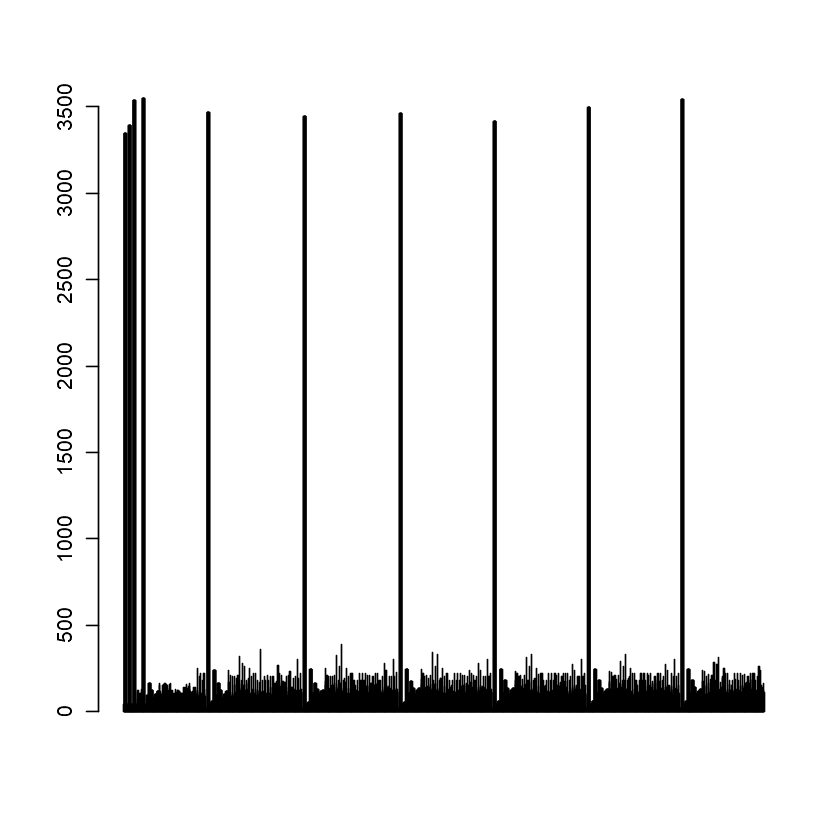

In [21]:
barplot(processed_food$price)

In [19]:
# I log price data because the variable is fairly skewed. Logged version of price data is more noramally dispersed.
full_india_data_completed$log_price<- log(full_india_data_completed$price)
staple_food$log_price_staple<- log(staple_food$price)
perishable_food$log_price_perishable<- log(perishable_food$price)
processed_food$log_price_processed<- log(processed_food$price)

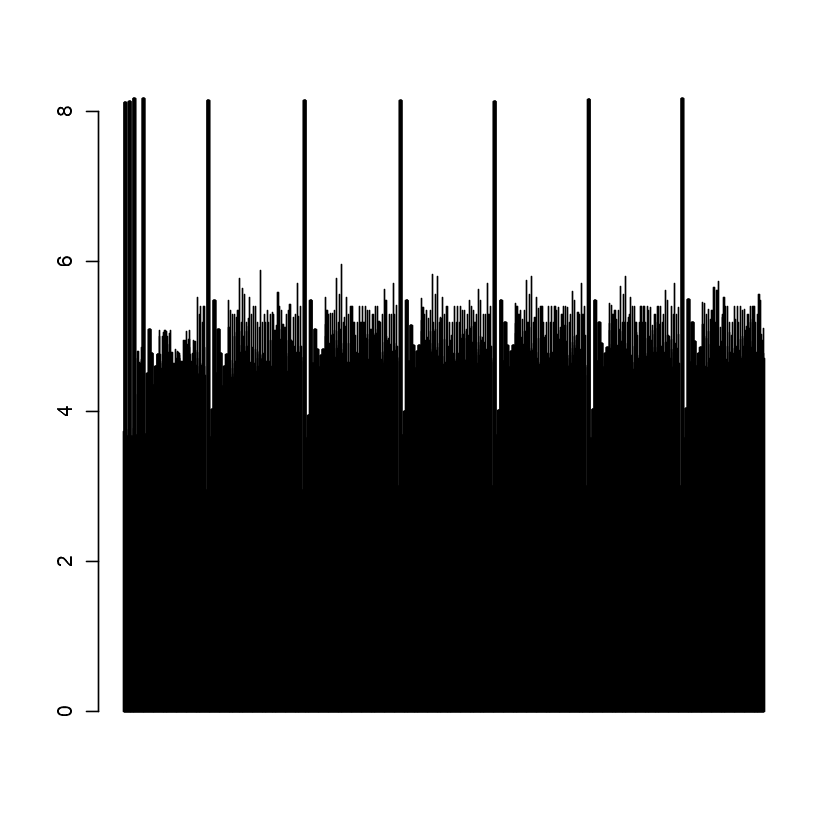

In [22]:
barplot(processed_food$log_price_processed)

## 5) Linear regression

I performed linear-regression on each food categories to find out the effect of COVID-19 lockdowns on different food category prices.

In [24]:
all_food_model <- lm(log_price ~ dummy_time + dummy_region + dummy_time * dummy_region, data = full_india_data_completed)

staple_food_model <- lm(log_price_staple ~ dummy_time + dummy_region + dummy_time * dummy_region, 
                                      data = staple_food)

perishable_food_model <- lm(log_price_perishable ~ dummy_time + dummy_region + dummy_time * dummy_region, 
                                      data = perishable_food)

processed_food_model <- lm(log_price_processed ~ dummy_time + dummy_region + dummy_time * dummy_region, 
                                      data = processed_food)

In [57]:
tidy(all_food_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.01080596,0.03769906,106.3900920,0.000000e+00
dummy_time,0.03820805,0.04364910,0.8753456,3.814123e-01
dummy_region,0.34294584,0.04627889,7.4104169,1.388195e-13
dummy_time:dummy_region,-0.09930961,0.05455994,-1.8201929,6.876716e-02


In [59]:
tidy(staple_food_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.7795172,0.06043858,62.534841,0.000000e+00
dummy_time,0.1769377,0.07188133,2.461525,1.388371e-02
dummy_region,0.5564923,0.07336318,7.585444,4.242957e-14
dummy_time:dummy_region,-0.1913382,0.08922881,-2.144354,3.207469e-02


In [60]:
tidy(perishable_food_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.52183889,0.04758939,74.0047018,0.00000000
dummy_time,-0.11017644,0.05236291,-2.1040930,0.03558908
dummy_region,-0.04479698,0.05530345,-0.8100215,0.41809700
dummy_time:dummy_region,0.13230195,0.06226293,2.1248911,0.03381054


In [58]:
tidy(processed_food_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.37705198,0.05168514,84.6868623,0.000000e+00
dummy_time,-0.03578185,0.05938002,-0.6025907,5.468213e-01
dummy_region,0.34060880,0.06570757,5.1837074,2.302444e-07
dummy_time:dummy_region,-0.13913652,0.07623579,-1.8250814,6.807670e-02


The results indicate that the price of staple and processed food decreased 19% and 13% in red zones; however, the pershable food prices increasd by 13%.